# Modeling for Explanation

Previously, we saw how modeling for prediction involved the selection of covariates guided by metrics for out-of-sample prediction. 

In modeling for explanation, we seek to estimate the effects of covariates on an outcome of interest, while minimizing confounders and biases
- We need to consider biases like collinearity from correlated covariates as they impact the interpretation of the effect sizes
- We need to consider the causal relationships among the covariates so we can identify confounders and decide which covariates to include/exclude

Here, we will look at how we can make use of causal graphs to identify biases

![modeling_explain.png](images/modeling_explain.png)


---
## Causal graphs

Causal models can be represented as directed graphs where 
- The outcome and covariates are represented as `nodes`
- The causal links are represented as directional `edges` (arrows)

![modeling_causal_graph.png](images/modeling_causal_graph.png)

In these models, the graphs are acyclic (known as **directed acyclic graphs** or **DAGs**) where the paths connecting the nodes do not form a cycle

![modeling_acyclic.png](images/modeling_acyclic.png)

---
## Confounder types

Let us consider a minimal causal DAG with the following variables
- `X` is the exposure covariate
- `Y` is the outcome of interest
- `Z` is another covariate

Using this minimal DAG, we can identify the following confounder types

![modeling_confounder.png](images/modeling_confounder.png)

We will explore these confounder types using simulated datasets
- Fork
- Pipe
- Collider

We will see how we can model the causal graphs using the `ggdag` library as well as a web-based tool http://www.dagitty.net/dags.html

In [1]:
library(tidyverse)
library(ggdag) # for causal dags

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘ggdag’


The following object is masked from ‘package:stats’:

    filter




We will define a convenience `table_lm` function to print the regression tables using `stargazer`

In [2]:
table_lm <- function(...) {
    
   capture.output(stargazer::stargazer(..., ci=TRUE, type="html")) %>%
   paste(collapse="") %>% IRdisplay::display_html()
   
}

## 1. Fork

In this example, we have a synthetic dataset with `age`, `smoking` and `COPD` variables
- `age` years
- `smoking` amount (arbitrary units)
- `COPD` severity (arbitrary units)

In [3]:
set.seed(1896) # Reproducibility 
n <- 1000 # Sample Size

# synthetic model
age <- rnorm(n, mean = 20, sd = 15) 
smoking <- 150 - age + rnorm(n)
COPD <- 0.5 * age + 0.1 * smoking + rnorm(n)

data_fork <- tibble(age=age,
                    smoking=smoking,
                    COPD=COPD)
head(data_fork)

age,smoking,COPD
<dbl>,<dbl>,<dbl>
50.50475,100.3208,33.91562
22.01991,127.1552,24.42866
28.96818,121.8219,27.22487
20.95888,128.7240,23.31160
23.25103,128.2533,23.47388
20.51135,129.7942,22.81942


We are interested in finding out the effect of `smoking` on `COPD`

We can build an initial model looking at the effect of `smoking` on `COPD`

In [4]:
model_fork <- lm(COPD ~ smoking, data_fork)

table_lm(model_fork)

Dependent variable: COPD smoking -0.401 *** (-0.405, -0.396) Constant 75.111 *** (74.518, 75.704) Observations 1,000 R 2 0.968 Adjusted R 2 0.968 Residual Std. Error 1.080 (df = 998) F Statistic 30,248.220 *** (df = 1; 998) Note: * p<0.1; ** p<0.05; *** p<0.01

Curiously, we see that the amount of `smoking` reduces `COPD`, contrary to what we expect based on our understanding of pathophysiology

To understand this, we can build a DAG relating the 3 variables `smoke`, `age` and `COPD`, based on our background knowledge
- `smoke` (exposure) is linked to `COPD` (outcome)
- `age` is linked to both `smoke` and `COPD`

We use the `dagify` function to build the graph and the `ggdag` function to visualize it

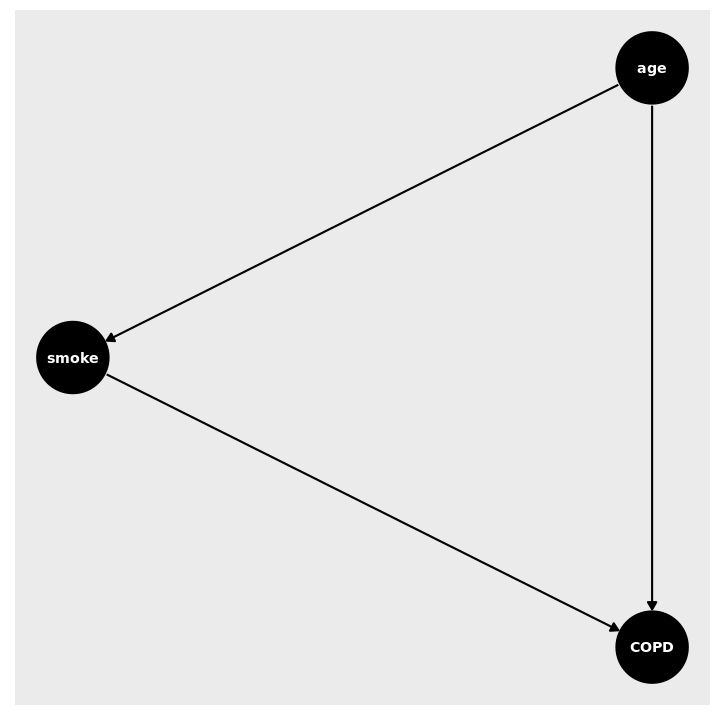

In [5]:
dag_fork <- dagify(smoke ~ age,
                   COPD ~ age,
                   COPD ~ smoke,
                   exposure = "smoke",
                   outcome = "COPD")

# set plot dimensions
options(repr.plot.width=6, repr.plot.height=6)

ggdag(dag_fork, layout="auto", node_size = 20, text_size = 3) + theme_dag_grey()

We can use the `ggdag_adjustment_set` to indicate possible confounders that should be adjusted for by including them in the model

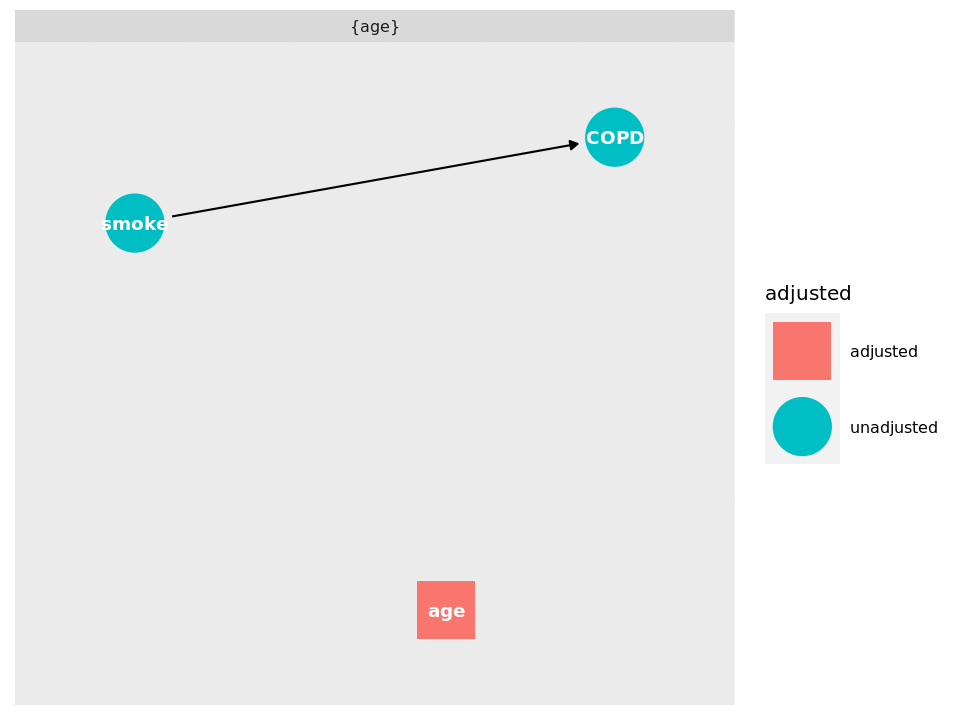

In [6]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=6)

ggdag_adjustment_set(dag_fork) + theme_dag_gray()

We can see that `age` is a possible confounder and we can include this covariate in our model to adjust for it

Let us also model this in http://www.dagitty.net/dags.html

In [7]:
model_fork_adjusted <- lm(COPD ~ smoking + age, data_fork)

table_lm(model_fork, model_fork_adjusted)

Dependent variable: COPD (1) (2) smoking -0.401 *** 0.082 ** (-0.405, -0.396) (0.020, 0.144) age 0.484 *** (0.422, 0.546) Constant 75.111 *** 2.694 (74.518, 75.704) (-6.626, 12.015) Observations 1,000 1,000 R 2 0.968 0.974 Adjusted R 2 0.968 0.974 Residual Std. Error 1.080 (df = 998) 0.973 (df = 997) F Statistic 30,248.220 *** (df = 1; 998) 18,750.910 *** (df = 2; 997) Note: * p<0.1; ** p<0.05; *** p<0.01

We can see now that when age is adjusted for, the conclusion is different and shows that smoking does increase COPD

![modeling_fork.png](images/modeling_fork.png)

## 2. Pipe

In this example, we have a synthetic dataset with `exercise`, `HR` and `sysBP` variables
- `exercise` intensity (arbitrary units)
- `HR` beats/min
- `sysBP` mmHg

In [8]:
set.seed(1896) # Reproducibility
n <- 1000 # Sample Size

# synthetic model
exercise <- rnorm(n)
HR <- 5 * exercise + rnorm(n) + 60
sysBP <- 2 * HR + rnorm(n)

data_pipe <- tibble(exercise=exercise, 
                HR=HR, 
                sysBP=sysBP)
head(data_pipe)

exercise,HR,sysBP
<dbl>,<dbl>,<dbl>
2.03365024,70.99385,140.6189
0.13466066,59.84845,120.4001
0.59787859,63.77945,128.1175
0.06392520,60.00253,119.9648
0.21673542,62.58798,124.1990
0.03408985,60.47600,120.5363


We are interested to find out the effect of `exercise` on `sysBP`

In this case, let us suppose we build a model that includes all the covariates so that we can estimate the effect of `exercise` on `sysBP`

In [9]:
model_pipe_adjusted <- lm(sysBP ~ exercise + HR, data_pipe)

table_lm(model_pipe_adjusted)

Dependent variable: sysBP exercise 0.122 (-0.197, 0.440) HR 1.982 *** (1.920, 2.044) Constant 1.091 (-2.638, 4.820) Observations 1,000 R 2 0.991 Adjusted R 2 0.991 Residual Std. Error 0.973 (df = 997) F Statistic 54,402.820 *** (df = 2; 997) Note: * p<0.1; ** p<0.05; *** p<0.01

Interestingly, now we see that `HR` has an effect on `sysBP` as expected, but `exercise` does not have a significant effect, contrary to what we know about  physiological responses

To understand this, let us build a DAG linking `exercise`, `HR` and `sysBP` using the `dagify` function
- `exercise` (exposure) is linked to `HR`
- `HR` is linked to `sysBP` (outcome)

We can visualize the DAG using the `ggdag` function

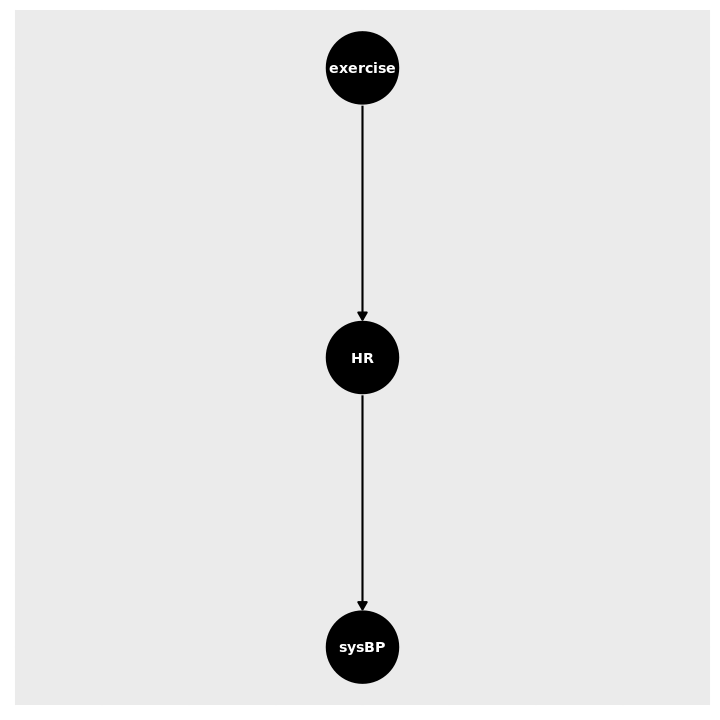

In [10]:
library(ggdag)

# set plot dimensions
options(repr.plot.width=6, repr.plot.height=6)

dag_pipe <- dagify(sysBP ~ HR,
                   HR ~ exercise,
                   exposure = "exercise",
                   outcome = "sysBP")

ggdag(dag_pipe, layout = "auto", node_size = 20, text_size = 3) + theme_dag_grey()

We use the `ggdag_adjustment_set` to visualize any covariates that should be adjusted for

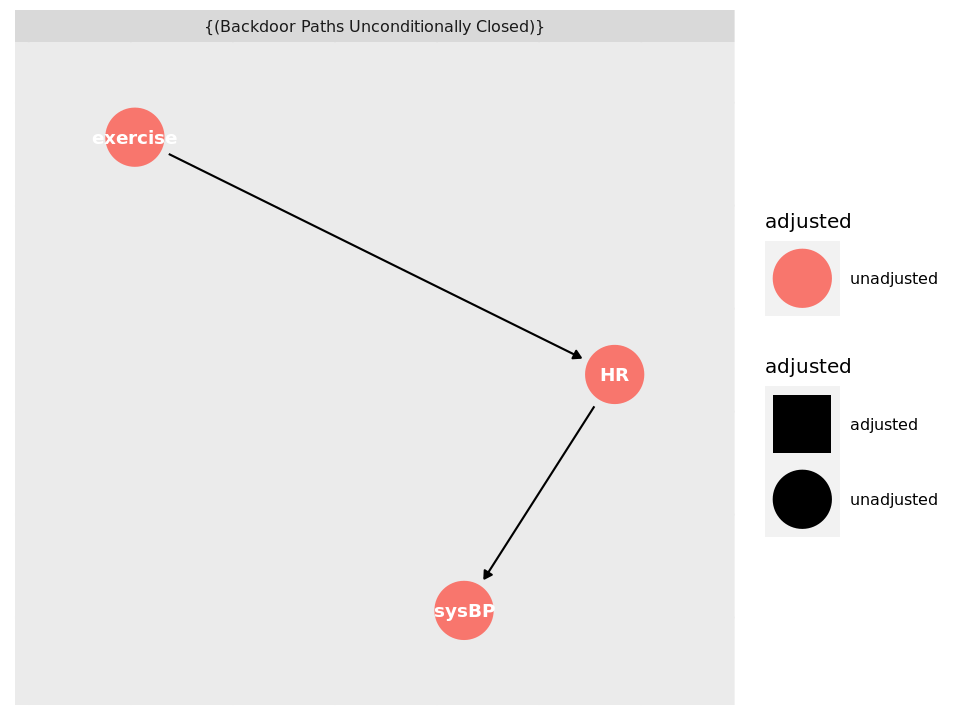

In [11]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=6)

ggdag_adjustment_set(dag_pipe) + theme_dag_grey()

We see that there are no covariates that have been recommended for adjustment

Let us see what happens when we adjust for `HR` using the `ggdag_adjust` function

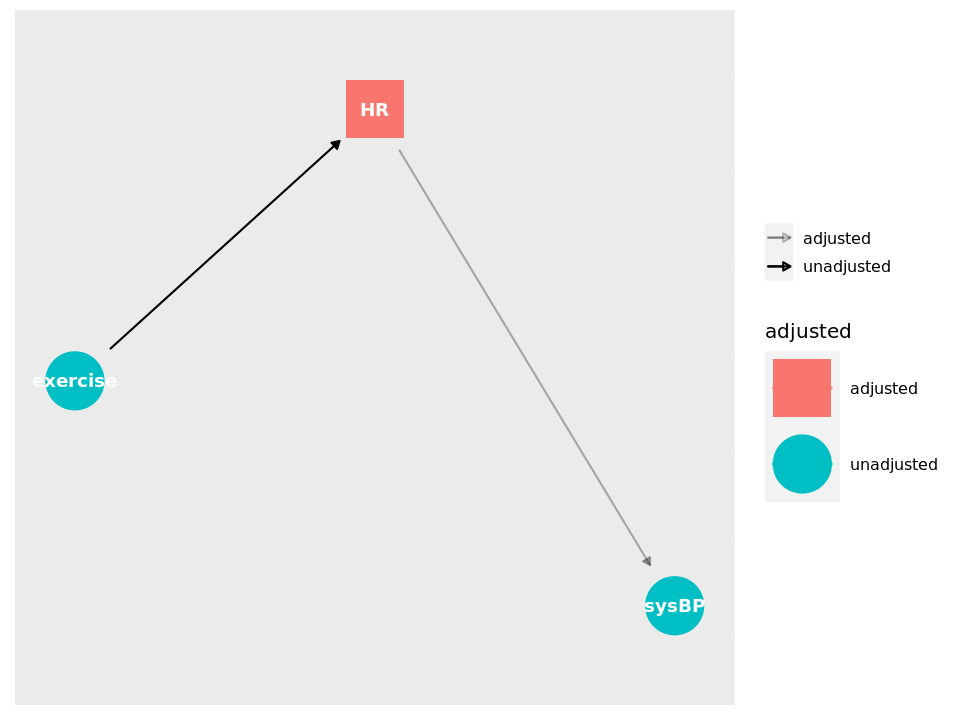

In [12]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=6)

ggdag_adjust(dag_pipe,var="HR") + theme_dag_grey()

We see that adjusting for `HR` would actually block the path from `exercise` to `sysBP`, making it impossible to estimate the effect of `exercise` on `sysBP`

- Let us also model this in http://www.dagitty.net/dags.html

We can build another model where we exclude `HR` and compare it to our initial full model

In [13]:
model_pipe <- lm(sysBP ~ exercise, data_pipe)
model_pipe_adjusted <- lm(sysBP ~ exercise + HR, data_pipe)

table_lm(model_pipe_adjusted, model_pipe)

Dependent variable: sysBP (1) (2) exercise 0.122 10.090 *** (-0.197, 0.440) (9.955, 10.226) HR 1.982 *** (1.920, 2.044) Constant 1.091 119.984 *** (-2.638, 4.820) (119.850, 120.117) Observations 1,000 1,000 R 2 0.991 0.955 Adjusted R 2 0.991 0.955 Residual Std. Error 0.973 (df = 997) 2.156 (df = 998) F Statistic 54,402.820 *** (df = 2; 997) 21,355.460 *** (df = 1; 998) Note: * p<0.1; ** p<0.05; *** p<0.01

We can now see that `exercise` does increase increase `sysBP`

![modeling_pipe.png](images/modeling_pipe.png)

## 3. Collider

In this example, we have a synthetic dataset with `DKA`, `AMI` and `ICU` variables
- `DKA` risk score (arbitrary unit)
- `AMI` risk score (arbitrary unit)
- `ICU` admission (1=yes, 0=no)

In [14]:
set.seed(1896) # Reproducibility
n <- 1000 # Sample Size 

DKA <- rnorm(n)^2 
AMI <- rnorm(n)^2

ICU <- ((DKA > 1) | (AMI > 1))
luck <- rbinom(n, size = 1, prob = 0.05) 
ICU <- (1 - luck) * ICU + luck * (1 - ICU)

data_collider <- tibble(DKA=DKA,
                        AMI=AMI,
                        ICU=factor(ICU))
head(data_collider)

DKA,AMI,ICU
<dbl>,<dbl>,<fct>
4.135733296,0.68160927,1
0.018133494,0.68037601,0
0.357458803,0.62418544,0
0.004086431,0.10054905,0
0.046974242,2.26293810,1
0.001162118,0.09336329,0


We are interested to find out the effect of `DKA` on `AMI`

Let us build an initial model looking at the association between `DKA` and `AMI` by including the `ICU` covariate

In [15]:
model_collider_adjusted <- lm(AMI ~ DKA + ICU, data_collider)

table_lm(model_collider_adjusted)

Dependent variable: AMI DKA -0.181 *** (-0.239, -0.124) ICU1 1.276 *** (1.118, 1.435) Constant 0.442 *** (0.337, 0.548) Observations 1,000 R 2 0.200 Adjusted R 2 0.199 Residual Std. Error 1.144 (df = 997) F Statistic 124.904 *** (df = 2; 997) Note: * p<0.1; ** p<0.05; *** p<0.01

Interestingly, `DKA` decreases `AMI` risk in this model, contrary from what we may expect from pathophysiology

To understand this, let us build a causal graph linking `AMI`, `DKA` and `ICU` using the `dagify` function
- `DKA` (exposure) is linked to `AMI` (outcome)
- `DKA` is linked to `ICU` admission
- `AMI` is linked to `ICU` admission

We can visualize the DAG using the `ggdag` function

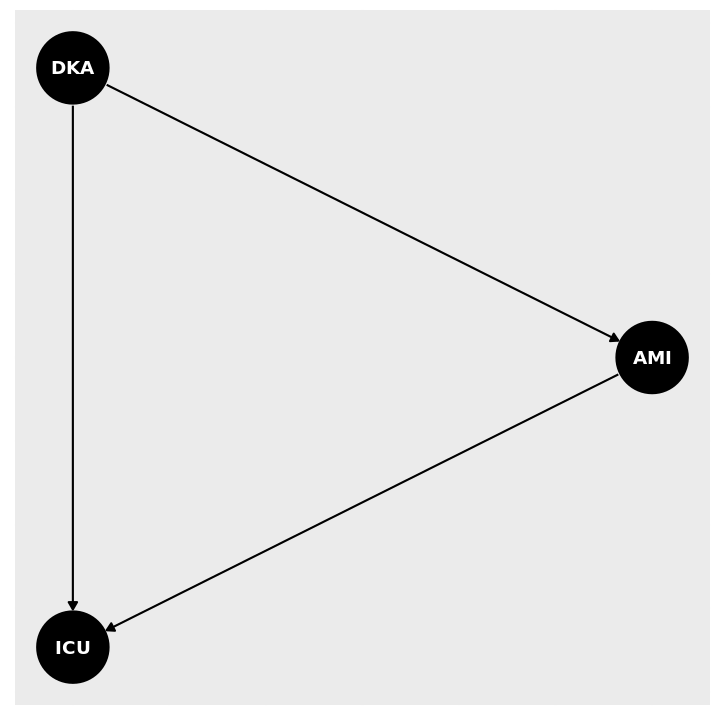

In [16]:
dag_collider <- dagify(ICU ~ DKA,
                       ICU ~ AMI,
                       AMI ~ DKA,
                       exposure = "DKA",
                       outcome = "AMI")

# set plot dimensions
options(repr.plot.width=6, repr.plot.height=6)

ggdag(dag_collider, layout = "circle", node_size = 20) + theme_dag_grey()

We use the `ggdag_adjustment_set` to visualize any covariates that should be adjusted for

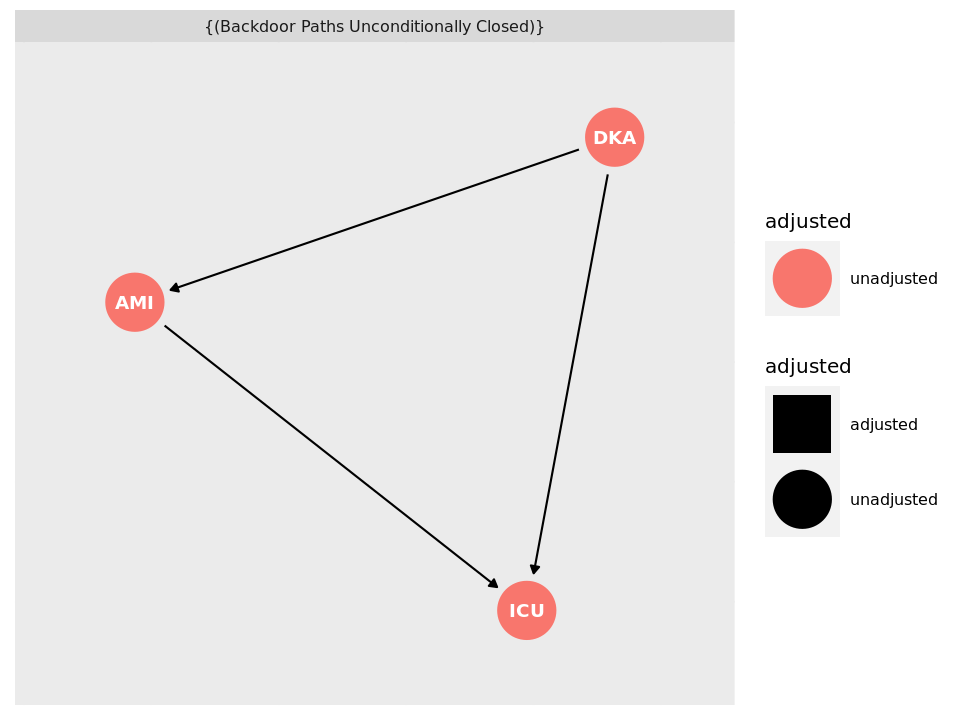

In [17]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=6)

ggdag_adjustment_set(dag_collider) + theme_dag_grey()

We see that there are no covariates that have been recommended for adjustment

Let us see what happens when we adjust for `ICU` using the `ggdag_adjust` function

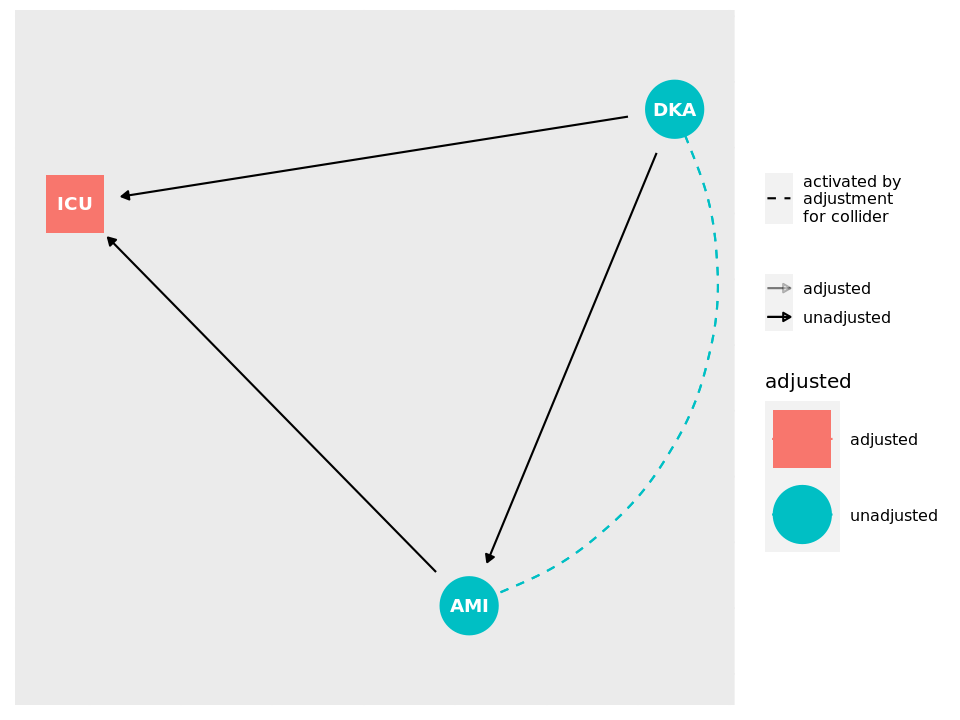

In [18]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=6)

ggdag_adjust(dag_collider, var = "ICU") + theme_dag_grey()

We can see that the adjustment of `ICU` admissions will spuriously lead to an association between `DKA` and `AMI` even when there is no effect
- Let us also model this in http://www.dagitty.net/dags.html

We can build a model where the `ICU` covariate is excluded and compare it to the adjusted model

In [19]:
model_collider <- lm(AMI ~ DKA, data_collider)
model_collider_adjusted <- lm(AMI ~ DKA + ICU, data_collider)

table_lm(model_collider_adjusted, model_collider)

Dependent variable: AMI (1) (2) DKA -0.181 *** 0.023 (-0.239, -0.124) (-0.034, 0.081) ICU1 1.276 *** (1.118, 1.435) Constant 0.442 *** 0.919 *** (0.337, 0.548) (0.822, 1.016) Observations 1,000 1,000 R 2 0.200 0.001 Adjusted R 2 0.199 -0.0004 Residual Std. Error 1.144 (df = 997) 1.278 (df = 998) F Statistic 124.904 *** (df = 2; 997) 0.640 (df = 1; 998) Note: * p<0.1; ** p<0.05; *** p<0.01

We can see that when we do not adjust for `ICU` covariate, the association between `AMI` and `DKA` is no longer significant

![modeling_collider.png](images/modeling_collider.png)

---
## Exercise - Modeling for explanation

For this exercise, we will use a dataset investigating the effect of smoking on FEV lung function from a study in 1979 on 606 children (6-17 years old)
- `age`: years
- `fev`: forced expiratory volume (L)
- `height`: inches
- `gender`: m = male, f = female
- `smoking`: 1 = smoker, 0 = non-smoker

In [ ]:
library(tidyverse)

data_fev <- read_tsv("https://raw.githubusercontent.com/kennethban/dataset/main/fev.txt") %>%
            mutate(gender = as.factor(gender),
                   smoking = as.factor(smoking),
                   height = height * 2.54) # convert to cm

head(data_fev)

We will use the `table_lm` convenience function for displaying tables of linear models

In [ ]:
table_lm <- function(...) {
    
   capture.output(stargazer::stargazer(..., ci=TRUE, type="html")) %>%
   paste(collapse="") %>% IRdisplay::display_html()
   
}

### Part 1

Build a model using `lm` and store it as `my_fit`
- `fev`: response variable
- `smoking`: covariate

Print the table using `table_lm` convenience function
- Interpret the coefficient

In [ ]:
# start here

In [ ]:
# solution

my_fit <- lm(fev ~ smoking, data_fev)

table_lm(my_fit)

### Part 2

Use http://www.dagitty.net/dags.html to build a plausible causal DAG 
- `smoking`: exposure variable
- `fev`: outcome variable
- `age`
- `height`
- `gender`

After building the causal DAG
- Identify the minimal set of covariates to adjust for to control for confounders
- Fit the adjusted model using `lm` and store it as `my_fit_adjusted`

Print both `my_fit` and `my_fit_adjusted` using `table_lm` convenience function
- Interpret the coefficients

In [ ]:
# start here

In [ ]:
# solution

my_fit_adjusted <- lm(fev ~ smoking + age + gender + height, data_fev)

table_lm(my_fit, my_fit_adjusted)